# Model V0.2
@ 2020/11/03

按照512 tokens 進行 Crop + Padding 

採用 Weighted Categorical CrossEntropy

In [1]:
import os 
os.chdir("/home/clll/AiIdea_text/")
import tensorflow as tf
from tensorflow.data import Dataset
import pandas as pd
from transformers import AutoTokenizer, TFAutoModel
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import math
import tensorflow.keras.backend as K
import numpy as np

In [2]:
train_text = pd.read_csv("./data/train_text.csv")
train_label = pd.read_csv("./data/train_label.csv")

## 進行斷詞

In [3]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-chinese")

因為尚未進行裁切，所以會顯示警告。

In [4]:
train_text['text_encoded'] = train_text.text.apply(lambda x: tokenizer.encode(list(x), add_special_tokens=False))

Token indices sequence length is longer than the specified maximum sequence length for this model (4212 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2653 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1690 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1230 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (768 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for

In [5]:
train_text

,article_id,text,text_encoded
0,0,醫師：啊回去還好嗎？民眾：欸，還是虛虛的，但。醫師：欸，真的。民眾：好險好險。坦白講我剛回去...,"[7015, 2374, 8038, 1557, 1726, 1343, 6917, 196..."
1,1,醫師：阿阿嬤她好像說有，前天又有在發燒喔。家屬：對阿都，有時候都會一天她會燒，誒，可是她這樣...,"[7015, 2374, 8038, 7350, 7350, 2085, 1961, 196..."
2,2,民眾：也有點不舒服，可是就是腰這邊有也一點點痛，我脫起來我想……。醫師：來我看一下。民眾：看...,"[3696, 4707, 8038, 738, 3300, 7953, 679, 5653,..."
3,3,醫師：謝謝你這樣幫忙他們這樣，那最近還好嗎？民眾：就是因為不太好所以才要再回診，因為我為甚麼...,"[7015, 2374, 8038, 6342, 6342, 872, 6857, 3564..."
4,4,醫師：那個，吃藥還Ok嗎？民眾：OK。醫師：沒什麼問題？民眾：沒有。醫師：我們這次CD4是3...,"[7015, 2374, 8038, 6929, 943, 8024, 1391, 5973..."
...,...,...,...
115,115,醫師：所以今天是爲了暴露前預防嘛？民衆：嗯。醫師：你身邊有其他人在吃的嗎？民衆：沒有欸。醫師...,"[7015, 2374, 8038, 2792, 809, 791, 1921, 3221,..."
116,116,醫師：所以你這個月，你是任務型嗎？民眾：對。醫師：阿吃幾組？民眾：我印象中應該有4組。醫師：...,"[7015, 2374, 8038, 2792, 809, 872, 6857, 943, ..."
117,117,醫師：這個月還好嗎？民衆：這個月還好，上班比較無聊而已。醫師：還可以，上班沒有人有聊的啊。所...,"[7015, 2374, 8038, 6857, 943, 3299, 6917, 1962..."
118,118,醫師：那所以今天是要這個暴露前預防？民眾：對。醫師：欸……你，怎麼知道我們的？民眾：因為我是...,"[7015, 2374, 8038, 6929, 2792, 809, 791, 1921,..."


順便觀察每篇對話的character數量 (接下來可以發現 Label 極度不平均)

In [6]:
train_text.text_encoded.apply(lambda x: len(x)).describe()

count     120.000000
mean     2110.950000
std      1133.878299
min       568.000000
25%      1286.750000
50%      1763.000000
75%      2625.250000
max      7310.000000
Name: text_encoded, dtype: float64

## 整理 Label 欄位

In [7]:
train_label

,article_id,start_position,end_position,entity_text,entity_type
0,0,69,71,前天,time
1,0,75,77,前天,time
2,0,738,740,85,med_exam
3,0,741,744,102,med_exam
4,0,809,811,前年,time
...,...,...,...,...,...
2131,119,1136,1138,彰化,location
2132,119,1143,1145,彰化,location
2133,119,1173,1177,彰化醫院,location
2134,119,1216,1221,陳明明醫師,name


In [8]:
result = {}
for a_id in train_text.article_id.iloc:
    text_encoded = train_text.query("article_id=={}".format(a_id)).iloc[0].text_encoded
    label = ["other"] * len(text_encoded)
    # ground truth
    gt = train_label.query("article_id=={}".format(a_id))

    for _, a_gt in gt.iterrows():
        start_pos = a_gt.start_position
        end_pos = a_gt.end_position
        entity_type = a_gt.entity_type
        position = list(range(int(start_pos), int(end_pos)))
        for x, y in zip(position, [entity_type] * len(position)):
            label[x] = y
    result[a_id] = label

In [9]:
label_preprocessed = pd.DataFrame({"article_id":result.keys(), "label":result.values()})
label_preprocessed

,article_id,label
0,0,"[other, other, other, other, other, other, oth..."
1,1,"[other, other, other, other, other, other, oth..."
2,2,"[other, other, other, other, other, other, oth..."
3,3,"[other, other, other, other, other, other, oth..."
4,4,"[other, other, other, other, other, other, oth..."
...,...,...
115,115,"[other, other, other, other, other, time, time..."
116,116,"[other, other, other, other, other, other, tim..."
117,117,"[other, other, other, time, time, time, other,..."
118,118,"[other, other, other, other, other, other, tim..."


將label轉換成index

In [10]:
temp = list()
for i in label_preprocessed.label:
    temp += i
count = pd.DataFrame({'code':temp}).code.value_counts()
label2idx = {v:k for (k,v) in enumerate(count.keys())}
count

other             246748
time                4578
med_exam             606
name                 453
location             401
money                272
contact               98
family                53
profession            53
ID                    23
clinical_event        20
education              6
organization           3
Name: code, dtype: int64

In [11]:
label2idx['[PAD]'] = len(label2idx)
label2idx

{'other': 0,
 'time': 1,
 'med_exam': 2,
 'name': 3,
 'location': 4,
 'money': 5,
 'contact': 6,
 'family': 7,
 'profession': 8,
 'ID': 9,
 'clinical_event': 10,
 'education': 11,
 'organization': 12,
 '[PAD]': 13}

In [12]:
label_preprocessed["label_encoded"] = label_preprocessed.label.apply(lambda x:[label2idx[ele] for ele in x])

In [13]:
label_preprocessed

,article_id,label,label_encoded
0,0,"[other, other, other, other, other, other, oth...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,1,"[other, other, other, other, other, other, oth...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, ..."
2,2,"[other, other, other, other, other, other, oth...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,3,"[other, other, other, other, other, other, oth...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,4,"[other, other, other, other, other, other, oth...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...
115,115,"[other, other, other, other, other, time, time...","[0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
116,116,"[other, other, other, other, other, other, tim...","[0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, ..."
117,117,"[other, other, other, time, time, time, other,...","[0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, ..."
118,118,"[other, other, other, other, other, other, tim...","[0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, ..."


把處理好的文章跟label Merge成同一個Data Frame

In [14]:
preprocessed_df = pd.merge(train_text, label_preprocessed)
preprocessed_df

,article_id,text,text_encoded,label,label_encoded
0,0,醫師：啊回去還好嗎？民眾：欸，還是虛虛的，但。醫師：欸，真的。民眾：好險好險。坦白講我剛回去...,"[7015, 2374, 8038, 1557, 1726, 1343, 6917, 196...","[other, other, other, other, other, other, oth...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,1,醫師：阿阿嬤她好像說有，前天又有在發燒喔。家屬：對阿都，有時候都會一天她會燒，誒，可是她這樣...,"[7015, 2374, 8038, 7350, 7350, 2085, 1961, 196...","[other, other, other, other, other, other, oth...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, ..."
2,2,民眾：也有點不舒服，可是就是腰這邊有也一點點痛，我脫起來我想……。醫師：來我看一下。民眾：看...,"[3696, 4707, 8038, 738, 3300, 7953, 679, 5653,...","[other, other, other, other, other, other, oth...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,3,醫師：謝謝你這樣幫忙他們這樣，那最近還好嗎？民眾：就是因為不太好所以才要再回診，因為我為甚麼...,"[7015, 2374, 8038, 6342, 6342, 872, 6857, 3564...","[other, other, other, other, other, other, oth...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,4,醫師：那個，吃藥還Ok嗎？民眾：OK。醫師：沒什麼問題？民眾：沒有。醫師：我們這次CD4是3...,"[7015, 2374, 8038, 6929, 943, 8024, 1391, 5973...","[other, other, other, other, other, other, oth...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...
115,115,醫師：所以今天是爲了暴露前預防嘛？民衆：嗯。醫師：你身邊有其他人在吃的嗎？民衆：沒有欸。醫師...,"[7015, 2374, 8038, 2792, 809, 791, 1921, 3221,...","[other, other, other, other, other, time, time...","[0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
116,116,醫師：所以你這個月，你是任務型嗎？民眾：對。醫師：阿吃幾組？民眾：我印象中應該有4組。醫師：...,"[7015, 2374, 8038, 2792, 809, 872, 6857, 943, ...","[other, other, other, other, other, other, tim...","[0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, ..."
117,117,醫師：這個月還好嗎？民衆：這個月還好，上班比較無聊而已。醫師：還可以，上班沒有人有聊的啊。所...,"[7015, 2374, 8038, 6857, 943, 3299, 6917, 1962...","[other, other, other, time, time, time, other,...","[0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, ..."
118,118,醫師：那所以今天是要這個暴露前預防？民眾：對。醫師：欸……你，怎麼知道我們的？民眾：因為我是...,"[7015, 2374, 8038, 6929, 2792, 809, 791, 1921,...","[other, other, other, other, other, other, tim...","[0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, ..."


## 裁切資料集

In [15]:
art_ids, input_ids, attn_masks, labels = list(), list(), list(), list()
for _, a_row in preprocessed_df.iterrows():
    art_id = a_row['article_id']
    text_encoded = a_row['text_encoded']
    label_encoded = a_row['label_encoded']
    if len(text_encoded) <= 512:
        result = tokenizer.prepare_for_model(text_encoded, max_length=512, padding='max_length', add_special_tokens=False)
        art_ids.append(art_id)
        input_ids.append(result['input_ids'])
        attn_masks.append(result['attention_mask'])
        label_encoded += [label2idx['[PAD]']] * (512 - len(label_encoded))
        labels.append(label_encoded)
    else:
        crop_num = math.ceil(len(a_row.text_encoded) / 512)
        for crop in range(crop_num):
            result = tokenizer.prepare_for_model(text_encoded[512*crop: 512*(crop+1)], max_length=512, padding='max_length', add_special_tokens=False)
            art_ids.append(art_id)
            input_ids.append(result['input_ids'])
            attn_masks.append(result['attention_mask'])
            insert_label = label_encoded[512*crop: 512*(crop+1)]
            if len(insert_label) < 512:
                insert_label += [label2idx['[PAD]']] * (512 - len(insert_label))
            labels.append(insert_label)
                

truncated_df = pd.DataFrame({'art_id':art_ids, 'input_id':input_ids, 'attn_mask':attn_masks, 'label':labels})

In [16]:
truncated_df

,art_id,input_id,attn_mask,label
0,0,"[7015, 2374, 8038, 1557, 1726, 1343, 6917, 196...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,0,"[4707, 8038, 749, 6237, 749, 6237, 511, 7015, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,0,"[3696, 4707, 8038, 3221, 511, 7015, 2374, 8038...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,0,"[1762, 6174, 7481, 8024, 2218, 3221, 1070, 165...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,0,"[1755, 4020, 4020, 4638, 6857, 3564, 511, 3696...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...
557,118,"[3229, 952, 3298, 3683, 6733, 5653, 3302, 671,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
558,118,"[3564, 511, 1678, 511, 3696, 4707, 8038, 6929,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, ..."
559,119,"[7015, 2374, 8038, 6929, 2792, 809, 872, 4412,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
560,119,"[6221, 2533, 3291, 2128, 1059, 671, 763, 1621,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


## 準備 Tensorflow Dataset 

In [29]:
all_code = list()

for _, row in truncated_df.iterrows():
    all_code += row.label

pd.DataFrame({'code':all_code}).code.value_counts()

0     246748
13     34430
1       4578
2        606
3        453
4        401
5        272
6         98
8         53
7         53
9         23
10        20
11         6
12         3
Name: code, dtype: int64

In [30]:
train_df = truncated_df.sample(n=int(truncated_df.shape[0]*0.9))
valid_df = truncated_df[~truncated_df.index.isin(train_df.index)]

In [31]:
train_df.shape, valid_df.shape

((505, 4), (57, 4))

確認所有的Label都有被裁切整齊

In [32]:
train_df.label.apply(lambda x: len(x)).describe()

count    505.0
mean     512.0
std        0.0
min      512.0
25%      512.0
50%      512.0
75%      512.0
max      512.0
Name: label, dtype: float64

In [33]:
train_dataset = Dataset.from_tensor_slices(({'input_ids':train_df.input_id.values.tolist(),'attn_masks':train_df.attn_mask.values.tolist()}, train_df.label.values.tolist()))
valid_dataset = Dataset.from_tensor_slices(({'input_ids':valid_df.input_id.values.tolist(),'attn_masks':valid_df.attn_mask.values.tolist()}, valid_df.label.values.tolist()))

## 建構模型

In [118]:
tf.keras.backend.clear_session()
bert_zh = TFAutoModel.from_pretrained("bert-base-chinese")
input_ids = tf.keras.layers.Input(shape=(512,), dtype='int32', name='input_ids')
attn_masks = tf.keras.layers.Input(shape=(512,), dtype='int32', name='attn_masks')
last_hidden_state, _ = bert_zh({'input_ids':input_ids, 'attention_mask':attn_masks})
X = tf.keras.layers.Dense(64, activation='relu')(last_hidden_state)
# X = tf.keras.layers.Dropout(0.5)(X)
X = tf.keras.layers.Dense(64, activation='relu')(X)
X = tf.keras.layers.Dense(14, activation='softmax')(X)
model = tf.keras.Model(inputs={'input_ids':input_ids, 'attn_masks':attn_masks}, outputs=X)

Some weights of the model checkpoint at bert-base-chinese were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the model checkpoint at bert-base-chinese.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


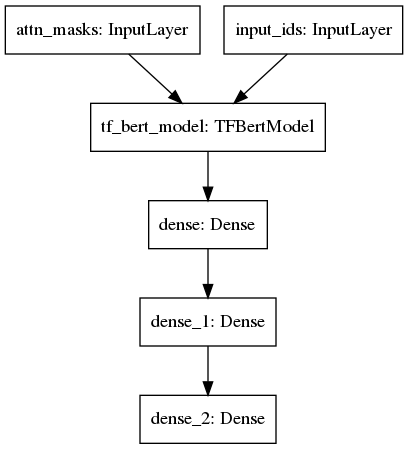

In [119]:
tf.keras.utils.plot_model(model)

In [120]:
model.get_layer('tf_bert_model').trainable=False
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
attn_masks (InputLayer)         [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_ids (InputLayer)          [(None, 512)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     ((None, 512, 768), ( 102267648   attn_masks[0][0]                 
                                                                 input_ids[0][0]                  
__________________________________________________________________________________________________
dense (Dense)                   (None, 512, 64)      49216       tf_bert_model[0][0]          

計算 Weights 

In [111]:
train_labels = list()
for i in train_df.label:
    train_labels += i
temp = pd.Series(train_labels).value_counts().to_dict()
train_labels = list()
for i in range(len(temp)):
    train_labels.insert(i, temp[i])
train_labels = np.array(train_labels)
weights = train_labels.sum() / train_labels

In [121]:
# Ref: https://gombru.github.io/2018/05/23/cross_entropy_loss/
def w_categorical_crossentropy(y_actual, y_pred):
    y_actual = tf.one_hot(tf.cast(y_actual, tf.int32), depth=14, dtype=tf.int32)
    # Like Softmax(?)
    y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
    # clip to prevent NaN's and Inf's (加上一個極小的值，避免對0取log會得到無限大)
    y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
    # calc
    loss = tf.cast(y_actual,y_pred.dtype) * K.log(y_pred) * weights
    loss = -K.sum(loss)
    return loss

In [122]:
def custom_loss(y_actual, y_pred):
    loss = tf.losses.sparse_categorical_crossentropy(y_actual, y_pred, from_logits=False)
    loss = tf.reduce_mean(loss)
    return loss

In [123]:
print(custom_loss(tf.cast(labels,predict.dtype), predict))
print(w_categorical_crossentropy(labels, predict))

tf.Tensor(4.98688, shape=(), dtype=float32)
tf.Tensor(22003.85, shape=(), dtype=float32)


In [124]:
def f1(y_true, y_pred):
    y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=14)
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [125]:
model.compile(loss=w_categorical_crossentropy, optimizer='adam', metrics=[tf.keras.metrics.SparseCategoricalAccuracy(), f1])

## Record : Simple Model + Weighted Loss ( weight = N / N_i )
**This is Feature Extraction Based (Due to the lack of data)**

**192->14**

|Finetune | Weight Function | Valid F1 Range | Notes |
|:------:|:---------------:|:--------:|:------:|
| No | No W| 0.95~ | f1 score 一直居高不下，但全都猜0 |
| No | W = N / N_i     |0.37~0.46| 少部分Class太容易出現了，感覺權重太強烈|
| No | W = log(N) / N_i^2 | ~0.40 | 偏差還是太嚴重 |
| Yes | W = N / N_i     | --- | 資料量並不適合使用Finetune<br>會全部都是0 |

**64->64->14**

既然 Training 表現都不夠，感覺是資料不足(?)

|Finetune | Weight Function | Valid F1 Range | Notes |
|:------:|:---------------:|:--------:|:------:|
| No | No W| 0.24~0.30 | Training F1 還是很低 |
| No | W = N / N_i || |

In [126]:
history = model.fit(
    x=train_dataset,
    batch_size=16, 
    epochs=100,
    validation_data=valid_dataset
)

Epoch 1/100
505/505 [==============================] - 9s 18ms/step - loss: 19913.5684 - sparse_categorical_accuracy: 0.1539 - f1: 0.1128 - val_loss: 8207.6953 - val_sparse_categorical_accuracy: 0.3629 - val_f1: 0.1824
Epoch 2/100
505/505 [==============================] - 8s 17ms/step - loss: 18740.8594 - sparse_categorical_accuracy: 0.1775 - f1: 0.1156 - val_loss: 8173.9375 - val_sparse_categorical_accuracy: 0.5727 - val_f1: 0.1824
Epoch 3/100
505/505 [==============================] - 8s 17ms/step - loss: 18095.6387 - sparse_categorical_accuracy: 0.1687 - f1: 0.1163 - val_loss: 7962.4224 - val_sparse_categorical_accuracy: 0.2948 - val_f1: 0.1824
Epoch 4/100
505/505 [==============================] - 8s 17ms/step - loss: 18047.5527 - sparse_categorical_accuracy: 0.1289 - f1: 0.1203 - val_loss: 8223.9609 - val_sparse_categorical_accuracy: 0.2163 - val_f1: 0.1824
Epoch 5/100
505/505 [==============================] - 8s 17ms/step - loss: 17834.2246 - sparse_categorical_accuracy: 0.1723

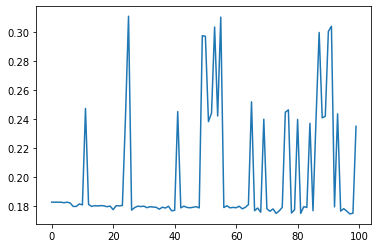

In [127]:
# No W (custom_loss)
plt.plot(history.history['val_f1'])

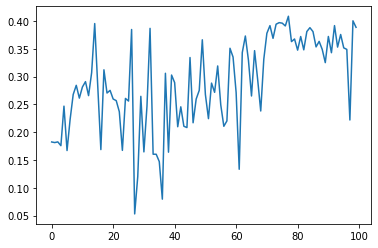

In [87]:
# W = log(N) / (N_i)^2
plt.plot(history.history['val_f1'])

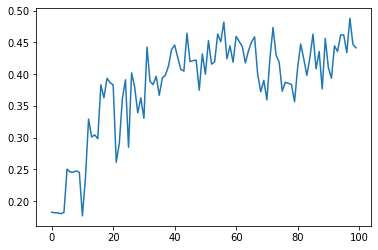

In [54]:
# W = N / N_i
plt.plot(history.history['val_f1'])

In [128]:
temp = iter(valid_dataset.batch(1))

In [129]:
( features, labels) = next(temp)
labels

<tf.Tensor: shape=(1, 512), dtype=int32, numpy=
array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
        1, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [130]:
predict = model.predict(x={'input_ids':features['input_ids'], 'attn_masks':features['attn_masks']})
predict.argmax(-1)

array([[ 3,  3, 11,  3,  3,  3, 11, 11,  3, 11, 12, 11, 12, 12, 11, 11,
        12, 11, 11, 11,  7,  3,  3, 11, 12,  3,  3,  7, 12, 12, 12, 12,
        12, 12, 12, 12, 12, 12, 11, 12, 11, 11, 11, 11, 12, 11, 12, 12,
         7, 12, 10, 12, 11,  3,  3,  3, 11, 12, 11, 11,  7, 12, 12,  3,
        11,  3, 11, 12, 11, 12, 11, 12, 11, 11, 11, 11, 11, 11, 11, 11,
        11, 11,  3,  3,  3, 11,  3, 11,  3, 11,  3,  3, 11,  0,  2, 11,
        11, 11, 11,  3,  3, 12, 12, 11, 12, 12, 11, 11, 11, 12, 10, 11,
         3,  3, 12, 11, 11, 12,  3, 12, 12,  3, 12, 12, 11, 12, 11,  3,
         3,  3,  3, 11, 12, 11, 12,  3,  3, 11, 12, 11,  3, 12, 11,  3,
        11, 12, 12,  7,  7, 11, 11, 10, 11, 11, 11,  7,  3, 11, 11, 12,
         7, 10,  9,  3,  3, 11,  3,  3,  3,  3, 12, 11, 11, 11,  3,  3,
        11, 11, 12, 12, 11,  3,  3,  3,  3,  3,  3, 11, 11, 11, 11, 12,
        11, 12, 11, 12, 12, 11,  3, 11,  3, 12,  3,  3,  3,  3, 11, 11,
         3,  3,  3,  3,  3, 11,  7,  3,  3, 11, 12, 12,  3,  3, 



## 結論 
V0.2 版本的模型，加入Weighted權重後，預測的值還是都很固定(不管輸入什麼樣的資料，輸出都長一模一樣)，而且輸出的分數都直接變成`0`, `1`

=> 後來釐清是因為Dense Layer不能使用 `Sigmoid`，要使用 `Softmax` (因為我們是Single Label 情境)

參考了別人使用 Keras 做 NER 的Model，有可能是資料筆數不太夠: 
[Reference - NER with Keras and tensorflow](https://towardsdatascience.com/named-entity-recognition-ner-meeting-industrys-requirement-by-applying-state-of-the-art-deep-698d2b3b4ede)

**V0.2版本的結論是：加入Weighted調整Loss的想法的確可以讓模型不要全部預測0，但是預測結果還是過度雜亂，尚且無法得到很好的效果**